# Mask Generation

Segmentation masks are given as rle encoded strings. I decided to approach this problem by first converting the encoded masks to images and saving them. The paired x,y data used to train the segmentation model are the training image and the saved segmentation image respectively. Since the segmentation model will only be trained on images with ships in them, masks will only be saved for ship containing images.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from skimage.morphology import label
import json

In [7]:
torch.backends.cudnn.benchmark=True

In [8]:
PATH = Path('F:/ships')

In [10]:
seg_df = pd.read_csv(PATH/'train_ship_segmentations_v2.csv')

In [11]:
seg_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [13]:
seg_df.shape

(231723, 2)

In [15]:
files = os.listdir(PATH/'train_v2')

In [16]:
len(files)

192556

In [18]:
def rle_encode(img, min_threshold=1e-3, max_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_threshold:
        return '' ## no need to encode if it's all zeros
    if max_threshold and np.mean(img) > max_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [19]:
def multi_rle_encode(img):
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2)) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [20]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [21]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [22]:
def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

The dataset contains 192556 images total. 42556 images contain ships with a total of 81723 distinct ship masks.

In [23]:
not_empty = pd.notna(seg_df.EncodedPixels)
not_empty.sum(), seg_df[not_empty].ImageId.nunique()

(81723, 42556)

In [25]:
(~not_empty).sum(), seg_df[~not_empty].ImageId.nunique()

(150000, 150000)

In [26]:
rle_0 = seg_df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
img_0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


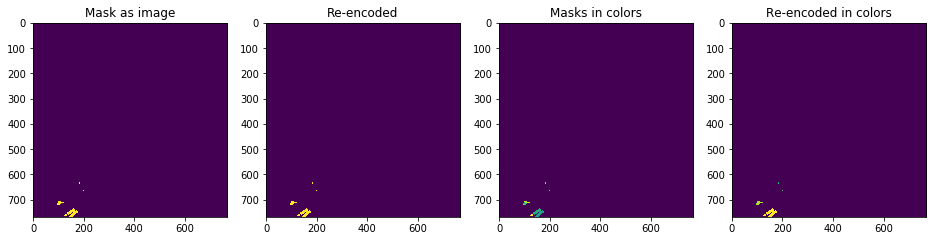

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = seg_df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

In [29]:
seg_df[not_empty].head()

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


In [31]:
seg_df['ships'] = seg_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [33]:
unique_img_ids = seg_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

In [34]:
unique_img_ids.head()

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0


In [36]:
ship_files = unique_img_ids[unique_img_ids.has_ship>0].ImageId.values

In [37]:
empty_files = unique_img_ids[unique_img_ids.has_ship==0].ImageId.values

In [38]:
len(ship_files), len(empty_files)

(42556, 150000)

In [39]:
seg_df[seg_df.ImageId.isin(ship_files)].head()

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [40]:
len(seg_df[seg_df.ImageId.isin(ship_files)].ImageId.unique())

42556

In [42]:
samp_df = seg_df[seg_df.ImageId.isin(ship_files)].copy()

In [43]:
samp_df.reset_index(inplace=True)

In [44]:
samp_df.head()

,index,ImageId,EncodedPixels,ships
0,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
1,3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
2,4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
3,5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
4,6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [45]:
samp_unique = unique_img_ids[unique_img_ids.ImageId.isin(ship_files)]

Some images contain multiple ships

In [46]:
samp_unique.head()

,ImageId,ships,has_ship
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
5,00021ddc3.jpg,9,1.0
6,0002756f7.jpg,2,1.0
9,00031f145.jpg,1,1.0


In [47]:
len(samp_unique.ImageId.unique())

42556

In [48]:
samp_unique.shape, samp_df.shape

((42556, 3), (81723, 4))

In [49]:
enc_group = samp_df.groupby('ImageId')

In [50]:
image_fns = samp_unique.ImageId.values

In [52]:
def get_mask(im, gb):
    rle = gb.get_group(im).EncodedPixels
    im_mask = masks_as_image(rle)

    im_mask = im_mask*255
    out_mask = np.stack([im_mask, im_mask, im_mask], axis=2)

    out_im = Image.fromarray(out_mask)

    fn = f'{im[:-4]}_mask.png'
    out_im.save(PATH/'masks'/fn, "PNG")

In [53]:
def multi_masks(filenames, gb):
    with ThreadPoolExecutor(8) as e:
        e.map(lambda x: get_mask(x, gb), filenames)

In [55]:
%time multi_masks(image_fns, enc_group)

Wall time: 2min 57s


In [57]:
mask_files = os.listdir(PATH/'masks')

In [59]:
ims = [open_image(PATH/'masks'/mask_files[i]) for i in range(16)]

In [60]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

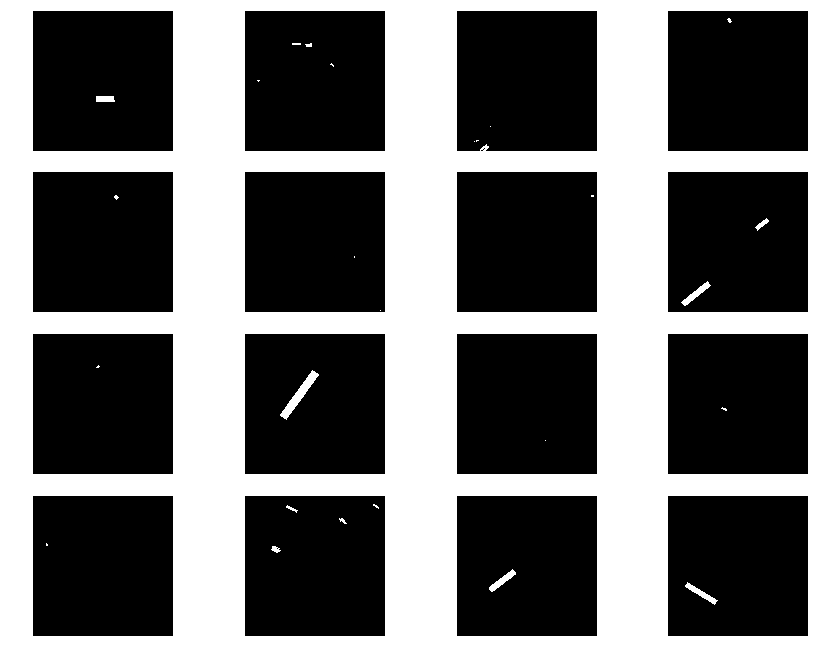

In [62]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    
plt.tight_layout(pad=0.1)

In [66]:
mask_to_ship = [i.split('_')[0] + '.jpg' for i in mask_files]

In [69]:
ship_ims = [open_image(PATH/'train_v2'/mask_to_ship[i]) for i in range(16)]

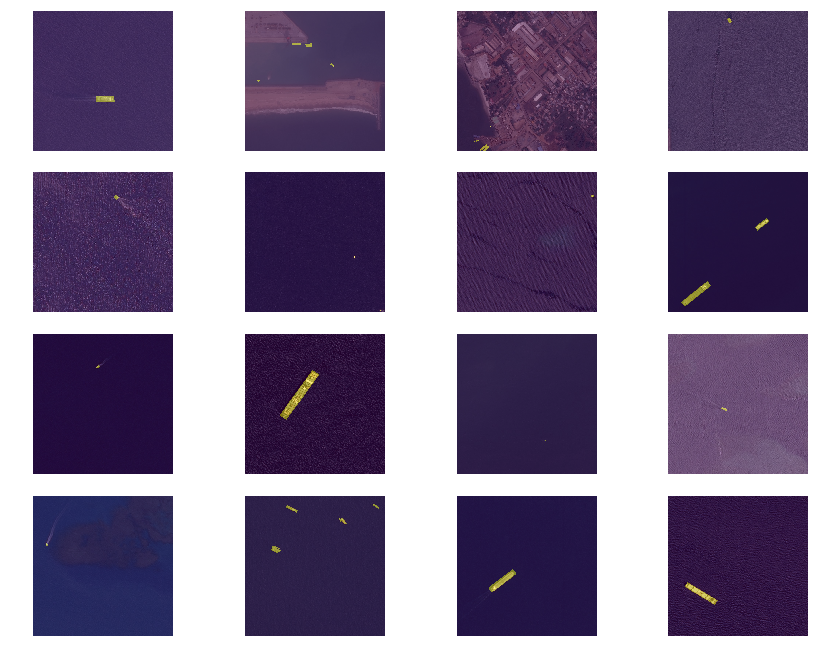

In [70]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax = show_img(ship_ims[i], ax=ax)
    show_img(ims[i][...,0], ax=ax, alpha=0.5)
    
plt.tight_layout(pad=0.1)